In [1]:
import sys 
sys.path.append('../')

import torch
import matplotlib.pyplot as plt 
from einops import repeat

import numpy as np
from src.dd_gmg import DD_GMG1D
from src.green_net import GreenNet1D
from src.model import MLP
from src.utils import rl2_error, matrl2_error
from src.dataset import load_dataset_1d
from dataset.generate_dataset_1d import poisson_kernel, logarithm_kernel
torch.set_printoptions(linewidth=120)

In [2]:
def logarithm_kernel(pts):
    x = pts[:,0]
    y = pts[:,1]
    nh = 513
    h = 2/(nh-1) # x in [-1, 1]

    a = x-y+h/2
    b = x-y-h/2
    k = (a*np.log(a.abs())-1) - (b*np.log(b.abs())-1)
    return k/h

def poisson_kernel(pts):
    x = (pts[:,0]+1)/2
    y = (pts[:,1]+1)/2
    nh = 513
    h = 1/(nh-1) # x in [-1, 1]

    a = -x*(y-1) * (x<(y-h/2))
    b = -y*(x-1) * (x>(y+h/2))
    c = ( (1-x)*( -0.5*(y-h/2)**2 + x**2/2) + (x * (h/2+y-x))-( x * (0.5*(h/2+y)**2 - x**2/2)))/h * ( (x>=(y-h/2)) & (x<=(y+h/2)) )
    return a+b+c

In [3]:
n = 9
device = torch.device('cpu')
model = GreenNet1D(n=n, kernel=poisson_kernel, device=device)
# F = torch.squeeze(1 - model.grid.x_h**2)

In [4]:
data_root = '/workdir/GreenMgNet/dataset'
train_loader, test_loader = load_dataset_1d('poisson', data_root, bsz=100, res=str(2**n+1))
F, U_ref = next(iter(train_loader))
U_ref = torch.squeeze(U_ref).T
F = torch.squeeze(F).T

In [5]:
model.eval_K()
K_full = model.K_hh.cpu().reshape(2**n+1, 2**n+1)

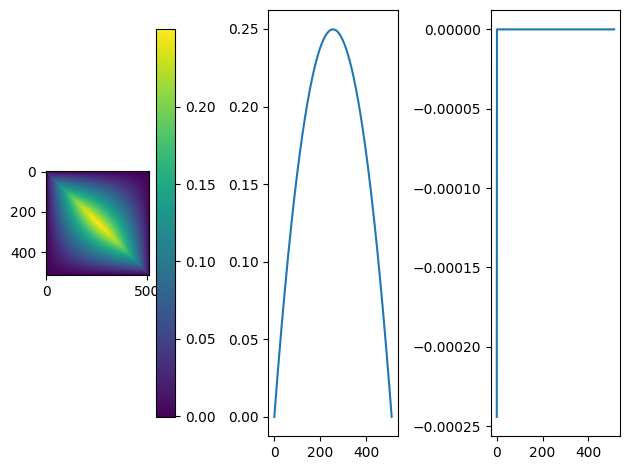

In [6]:
plt.subplot(131)
plt.imshow(K_full.cpu().reshape(2**n+1, 2**n+1))
plt.gca().set_aspect('equal')
plt.colorbar()
plt.subplot(132)
plt.plot(K_full.diag())
plt.subplot(133)
plt.plot(K_full[0])
plt.tight_layout()

In [7]:
U_full = model.full_kint(F)
print(U_full.shape)

torch.Size([513, 100])


Text(0.5, 1.0, 'output function U')

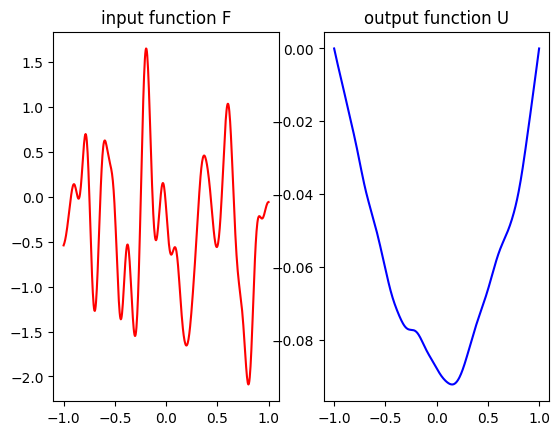

In [8]:
plt.subplot(121)
plt.plot(model.grid.x_h.cpu(), F[:,0].cpu(), '-r')
plt.title('input function F')
plt.subplot(122)
plt.plot(model.grid.x_h.cpu(), U_full[:,0].cpu(), '-b')
plt.title('output function U')

# Digonal Dominant Multi-Grid

influence of level of coarse: `k`

In [10]:
m = 1
for k in [1, 3, 5, 7]:
    dd_gmg = DD_GMG1D(n,m,k,poisson_kernel,device)
    dd_gmg.restrict_ml_f(F)
    dd_gmg.eval_ml_K()
    U_dd = dd_gmg.ml_kint(corr_odd=True)
    print('w   codd k {:d} - m {:d} - rl2 {:.4e}'.format(k, m, rl2_error(U_dd.T, U_full.T)))
    U_dd = dd_gmg.ml_kint(corr_odd=False)
    print('w/o codd k {:d} - m {:d} - rl2 {:.4e}'.format(k, m, rl2_error(U_dd.T, U_full.T)))

# coarest pts :  66049
# correction :  1790
ratio 67839/263169 = 25.78% 

w   codd k 1 - m 1 - rl2 1.2135e-06
w/o codd k 1 - m 1 - rl2 8.6902e-05
# coarest pts :  4225
# correction :  3130
ratio 7355/263169 = 2.79% 

w   codd k 3 - m 1 - rl2 1.0572e-05
w/o codd k 3 - m 1 - rl2 1.4253e-03
finest grid : 513
coarest grid : 17
too coarse warning
# coarest pts :  289
# correction :  3462
ratio 3751/263169 = 1.43% 

w   codd k 5 - m 1 - rl2 1.1092e-04
w/o codd k 5 - m 1 - rl2 2.0927e-02
finest grid : 513
coarest grid : 5
too coarse warning
# coarest pts :  25
# correction :  3542
ratio 3567/263169 = 1.36% 

w   codd k 7 - m 1 - rl2 1.0971e-03
w/o codd k 7 - m 1 - rl2 1.9709e-01


influence of correction range : `c`

In [12]:
k = 3

for m in [0, 1, 3, 7, 15, 31, 65, 129]:
    dd_gmg = DD_GMG1D(n,m,k,poisson_kernel,device)
    dd_gmg.restrict_ml_f(F)
    dd_gmg.eval_ml_K()

    U_dd = dd_gmg.ml_kint(corr_odd=True)
    print('w   codd k {:d} - m {:d} - rl2 {:.4e}'.format(k, m, rl2_error(U_dd.T, U_full.T)))

    U_dd = dd_gmg.ml_kint(corr_odd=False)
    print('w/o codd k {:d} - m {:d} - rl2 {:.4e}'.format(k, m, rl2_error(U_dd.T, U_full.T)))

# coarest pts :  4225
# correction :  0
ratio 4225/263169 = 1.61% 

w   codd k 3 - m 0 - rl2 1.6111e-03
w/o codd k 3 - m 0 - rl2 1.6111e-03
# coarest pts :  4225
# correction :  3130
ratio 7355/263169 = 2.79% 

w   codd k 3 - m 1 - rl2 1.0572e-05
w/o codd k 3 - m 1 - rl2 1.4253e-03
# coarest pts :  4225
# correction :  8440
ratio 12665/263169 = 4.81% 

w   codd k 3 - m 3 - rl2 1.0572e-05
w/o codd k 3 - m 3 - rl2 1.4253e-03
# coarest pts :  4225
# correction :  18844
ratio 23069/263169 = 8.77% 

w   codd k 3 - m 7 - rl2 1.0572e-05
w/o codd k 3 - m 7 - rl2 1.4253e-03
# coarest pts :  4225
# correction :  38788
ratio 43013/263169 = 16.34% 

w   codd k 3 - m 15 - rl2 1.0572e-05
w/o codd k 3 - m 15 - rl2 1.4253e-03
# coarest pts :  4225
# correction :  75220
ratio 79445/263169 = 30.19% 

w   codd k 3 - m 31 - rl2 1.0572e-05
w/o codd k 3 - m 31 - rl2 1.4253e-03
# coarest pts :  4225
# correction :  137340
ratio 141565/263169 = 53.79% 

w   codd k 3 - m 65 - rl2 1.0572e-05
w/o codd k 3 - m 65

In [ ]:
# from tqdm import trange
# import numpy as np
# from src.ops import interp1d_cols, interp1d_rows

In [ ]:
# k = 5
# m = 6
# dd_gmg = DD_GMG1D(n,m,k,Logarithm,device)
# dd_gmg.restrict_ml_f(F)
# dd_gmg.eval_ml_K()
# U_dd = dd_gmg.ml_kint()
# print(rl2_error(U_dd.T, U_full.T).numpy())

In [ ]:
# grid_H = dd_gmg.ml_grids[-1]
# K_HH = dd_gmg.K_HH

In [ ]:
# grid_h = dd_gmg.ml_grids[0]
# nh = grid_h.nh
# grid_h.init_grid_hh()
# K_hh = Logarithm(grid_h.x_hh).reshape(nh, nh)
# coords_ij = dd_gmg.ml_grids[0].coords_ij
# mask_ij = dd_gmg.ml_grids[0].mask_ij
# K_ij = K_hh[coords_ij[...,0], coords_ij[...,1]] * mask_ij

In [ ]:
# coords_IJ = dd_gmg.ml_grids[-1].coords_ij
# mask_IJ = dd_gmg.ml_grids[-1].mask_ij
# K_IJ = K_HH[coords_IJ[...,0], coords_IJ[...,1]] * mask_IJ
# l=1
# nh = dd_gmg.ml_grids[-1-l].nh
# hh = dd_gmg.ml_grids[-1-l].hh
            
# # local evaluation and assemblation
# K_local_even, K_local_odd = dd_gmg.K_locals[l-1]
# K_ij_ = dd_gmg.local_assemble_K(K_IJ, K_local_even, K_local_odd)
# K_2Ij = K_ij_[::2]
                
# # local kernel interpolation
# K_local_even_, K_local_odd_ = dd_gmg.local_interp_K(K_IJ, K_2Ij)

# _, coords_even, mask_even = dd_gmg.pts_local[l-1][0]
# _, coords_odd, mask_odd = dd_gmg.pts_local[l-1][1]

K_band correctness

In [ ]:
# K_hh

In [ ]:
# K_2Ij

K_even Correctness

In [ ]:
# K_hh[::2][:,1::2]

In [ ]:
# K_local_even

K_even Interp Correctness

In [ ]:
# interp1d_cols(K_HH[None,None])[0,0][:,1::2]

In [ ]:
# K_local_even_

K_odd Correctness

In [ ]:
# K_hh[1::2]

In [ ]:
# K_local_odd

K_odd Interp

In [ ]:
# (K_hh[::2][:-1] + K_hh[::2][1:])/2

In [ ]:
# K_local_odd_